# 深層学習スクラッチ 畳み込みニューラルネットワーク2

In [20]:
import numpy as np
# MNISTダウンロード
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 用意した画像データセットを変換
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)
print(X_train.shape, X_test.shape)

# 画素値を正規化処理
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.min(), X_train.max())
print(X_test.min(), X_test.max())

# trainとvalデータに分割
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)
0.0 1.0
0.0 1.0
(48000, 28, 28, 1) (12000, 28, 28, 1)
(48000,) (12000,)


【問題1】2次元畳み込み層の作成

In [181]:
class Flatten:
    def forward(self, N_in):
        self.H, self.W, self.C = N_in.shape
        return N_in.reshape(-1, self.C)
    
    def backward(self, d_in):
        return d_in.reshape(self.H, self.W, self.C)

class SimpleConv2d:
    def __init__(self, stride=1, padding=0, filter_size=(3, 3, 1)):
        self.padding = padding
        self.stride = stride
        self.filter_size = filter_size
        self.W = np.random.rand(self.filter_size[0], self.filter_size[1], self.filter_size[2])
        self.B = np.random.rand(self.filter_size[-1])
        self.lr = 0.01
        self.out_flatten = Flatten()
        self.x_flatten = Flatten()
        self.filter_flatten = Flatten()
        
        
    def compute_out(self, N_in, padding, filter_size, stride):
        self.x_h, self.x_w, self.x_c = N_in.shape
        self.f_h, self.f_w, self.f_c = self.W.shape
        N_h_out_shape = (self.x_h + 2 * padding - self.filter_size[0]) / stride + 1
        N_w_out_shape = (self.x_w + 2 * padding - self.filter_size[1]) / stride + 1
        return np.zeros((int(N_h_out_shape), int(N_w_out_shape), self.x_c))
        
    def forward(self, X):
        self.x = X
        N_out = self.compute_out(X, self.padding, self.filter_size, self.stride)
        self.x_flatten_array = self.x_flatten.forward(self.x)
        self.out_flatten_array = self.out_flatten.forward(N_out)
        self.filter_flatten_array = self.filter_flatten.forward(self.W)
        for c in range(self.out_flatten_array.shape[1]):
            for i in range(self.out_flatten_array.shape[0]):
                self.out_flatten_array[i, c] = np.sum(self.x_flatten_array[0+i:self.filter_flatten_array.shape[0]+i, c]\
                                        * self.filter_flatten_array) + self.B[c]
        N_out = self.out_flatten.backward(self.out_flatten_array)
        return N_out
            
    def backward(self, dA):
        self.dA_flatten = Flatten()
        self.dA_flatten_array = self.dA_flatten.forward(dA)
#         print(self.dA_flatten_array.shape)
#         self.delta_w = np.zeros(self.W.shape)
        self.delta_x = np.zeros(self.x_flatten_array.shape)
        self.delta_b = np.zeros(self.B.shape)
        for c in range(self.dA_flatten_array.shape[1]):
            self.delta_b[c] = np.sum(self.dA_flatten_array[c])
            self.B[c] = self.B[c] - self.lr * self.delta_b[c]
            for i in range(self.filter_flatten_array.shape[0]):
                self.filter_flatten_array[i, c] -= self.lr * (np.sum(self.dA_flatten_array\
                                                * self.x_flatten_array[0+i:self.dA_flatten_array.shape[0]+i, c]))
            
            for j in range(self.x_flatten_array.shape[0]):
                for s in range(self.filter_flatten_array.shape[0]):
                    loss_index = j - s
                    if loss_index < 0 or loss_index > dA.size - 1:
                        pass
                    else:
                        self.delta_x[j, c] += self.dA_flatten_array[loss_index, c] * self.filter_flatten_array[s, c]
        self.W = self.filter_flatten.backward(self.filter_flatten_array)          
        dZ = self.x_flatten.backward(self.delta_x)
        return dZ

In [22]:
%%time
# 新問題2確認
conv2d = SimpleConv2d()
a = conv2d.forward(X_train[0])
# print(conv2d.W)
da = conv2d.backward(a)
# print(conv2d.W)
print(a.shape, da.shape)
print(f'順伝搬後の出力特徴マップ:\n{a}')
print(f'逆伝搬後の出力特徴マップ:\n{da}')

(26, 26, 1) (28, 28, 1)
順伝搬後の出力特徴マップ:
[[[ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]]

 [[ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]]

 [[ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732]
  [ 0.13707732

【問題2】2次元畳み込み後の出力サイズ

In [26]:
def compute_out(N_in, padding, filter_size, stride):
    N_h_out_shape = (N_in.shape[0] + 2 * padding - filter_size.shape[0]) / stride + 1
    N_w_out_shape = (N_in.shape[1] + 2 * padding - filter_size.shape[1]) / stride + 1
    return np.zeros((int(N_h_out_shape), int(N_w_out_shape)))

In [27]:
# 確認
N_in = np.arange(100).reshape(10, 10)
padding = 0
filter_size = np.arange(9).reshape(3, 3)
stride = 1
N_out = compute_out(N_in, padding, filter_size, stride)
print(f'計算された出力サイズ：{N_out.shape[0]}, {N_out.shape[1]}')

計算された出力サイズ：8, 8


【問題3】最大プーリング層の作成

In [232]:
class MaxPool2D:
    def __init__(self, filter_size=(2, 2, 1), padding=0, stride=2):
        self.padding = padding
        self.filter_size = filter_size
        self.stride = stride
        self.out_flatten = Flatten()
        self.x_flatten = Flatten()
        self.filter_flatten = Flatten()
        self.dA_flatten = Flatten()
        
    def compute_out(self, N_in, padding, filter_size, stride):
        self.x_h, self.x_w, self.x_c = N_in.shape
        self.f_h, self.f_w, self.f_c = self.filter_size[0], self.filter_size[1], self.filter_size[2]
        N_h_out_shape = (self.x_h + 2 * padding - self.filter_size[0]) / stride + 1
        N_w_out_shape = (self.x_w + 2 * padding - self.filter_size[1]) / stride + 1
        return np.zeros((int(N_h_out_shape), int(N_w_out_shape), self.x_c))
    
    def forward(self, X):
        self.x = X
        f_h, f_w, f_c = self.filter_size[0], self.filter_size[1], self.filter_size[2]
        max_filter = np.zeros((f_h, f_w, f_c))
        N_out = self.compute_out(N_in=self.x, filter_size=self.filter_size, padding=self.padding, stride=self.stride)
        self.x_flatten_array = self.x_flatten.forward(self.x)
        self.out_flatten_array = self.out_flatten.forward(N_out)
        self.filter_flatten_array = self.filter_flatten.forward(max_filter)
        self.mask = np.arange(len(self.x_flatten_array))[:, np.newaxis]
        self.max_mask_index = np.zeros(self.out_flatten_array.shape)
        i = 0
        for c in range(self.x_c):
            for j in range(0, self.x_flatten_array.shape[0], f_h*f_w):
                self.out_flatten_array[i, c] = np.max(self.x_flatten_array[j:self.filter_flatten_array.shape[0]+j, c])
                max_index = np.argmax(self.x_flatten_array[0+j:self.filter_flatten_array.shape[0]+j, c])
                self.max_mask_index[i, c] = self.mask[0+j:self.filter_flatten_array.shape[0]+j, c][max_index]
                i += 1
        N_out = self.out_flatten.backward(self.out_flatten_array)
        self.unique_max_mask_index = list(np.unique(self.max_mask_index).astype(np.int))
        return N_out
    
    def backward(self, dA):
        self.dA_flatten_array = self.dA_flatten.forward(dA)
        self.delta_x = np.zeros(self.x_flatten_array.shape)
        go_ahead = 0
        for c in range(self.delta_x.shape[1]):
            for i in self.mask[:, c]:
                if i in self.unique_max_mask_index:
                    self.delta_x[i, c] = self.dA_flatten_array[go_ahead]
                    go_ahead += 1
                else:
                    self.delta_x[i, c] = 0
        dZ = self.x_flatten.backward(self.delta_x)
        return dZ

In [186]:
mask = np.arange(100).reshape(10, 10, 1)
N_in = np.random.rand(10,10,1)

mask_flatten = Flatten()
mask_flatten_array = mask_flatten.forward(mask)
flatten = Flatten()
n_in_flatten = Flatten()
filter_flatten = Flatten()
n_in_flatten_array = n_in_flatten.forward(N_in)
filter_size = np.arange(4).reshape(2, 2, 1)
filter_flatten_array = filter_flatten.forward(filter_size)
padding = 0
stride = 2
N_out = compute_out(N_in, padding, filter_size, stride)
N_out = N_out.reshape(5, 5, 1)
print(f'計算された出力サイズ：{N_out.shape[0]}, {N_out.shape[1]}')
out_flatten = flatten.forward(N_out)
max_mask_index = np.zeros(out_flatten.shape)
print(max_mask_index.shape)

計算された出力サイズ：5, 5
(25, 1)


In [235]:
# 確認
max_pool2d = MaxPool2D()
feature_map = max_pool2d.forward(X_train[0])
dZ = max_pool2d.backward(feature_map)
dZ

array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        

【問題4】（アドバンス課題）平均プーリングの作成

In [ ]:
class AvgPool2D:
    def __init__(self, filter_size, padding=0, stride=1):
        self.padding = padding
        self.filter_size = filter_size
        self.stride = stride
    
    def forward(self, N_in):
        H, W = N_in.shape
        f_h, f_w = self.filter_size.shape
        N_out = compute_out(N_in=N_in, filter_size=self.filter_size, padding=self.padding, stride=self.stride)
        for i in range(N_out.shape[0]):
            for j in range(N_out.shape[1]):
                print(N_in[i:f_h+i, j:f_w+j])
                N_out[i, j] = np.ceil(np.mean(N_in[i:f_h+i, j:f_w+j].reshape(-1)))
        return N_out

In [ ]:
pool_size = np.zeros((2, 2))
avg_pool2d = AvgPool2D(filter_size=pool_size)
feature_map = avg_pool2d.forward(N_in)
feature_map

【問題5】平滑化

In [ ]:
class Flatten:
    def forward(N_in):
        H, W, C = N_in.shape
        return N_in.reshape(-1)
    
    def backward(d_in):
        return d_in.reshape(H, W, C)

In [ ]:
# 確認
a = np.zeros((3, 4, 5))
flatten = Flatten()
a_out = flatten.forward(a)
d_out = flatten.backward(a_out)
print(f'original dim：{a.shape}')
print(f'順伝搬(3dim to 1dim)：{a_out.shape}')
print(f'逆伝搬(1dim to 3dim)：{d_out.shape}')

【問題6】学習と推定

In [19]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数
        Returns
        ----------
        W :
        """
        return self.sigma * np.random.rand(n_nodes1, n_nodes2)

    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数
        Returns
        ----------
        B :
        """
        return self.sigma * np.random.rand(n_nodes2)

class Flatten:
    def forward(self, N_in):
        self.H, self.W, self.C = N_in.shape
        return N_in.reshape(-1, self.C)
    
    def backward(self, d_in):
        return d_in.reshape(self.H, self.W, self.C)


class SimpleConv2d:
    def __init__(self, stride=1, padding=0, filter_size=(3, 3, 1)):
        self.padding = padding
        self.stride = stride
        self.filter_size = filter_size
        self.W = np.random.rand(self.filter_size[0], self.filter_size[1], self.filter_size[2])
        self.B = np.random.rand(self.filter_size[-1])
        self.lr = 0.01
        self.out_flatten = Flatten()
        self.x_flatten = Flatten()
        self.filter_flatten = Flatten()
        
        
    def compute_out(self, N_in, padding, filter_size, stride):
        self.x_h, self.x_w, self.x_c = N_in.shape
        self.f_h, self.f_w, self.f_c = self.W.shape
        N_h_out_shape = (self.x_h + 2 * padding - self.filter_size[0]) / stride + 1
        N_w_out_shape = (self.x_w + 2 * padding - self.filter_size[1]) / stride + 1
        return np.zeros((int(N_h_out_shape), int(N_w_out_shape), self.x_c))
        
    def forward(self, X):
        self.x = X
        N_out = self.compute_out(X, self.padding, self.filter_size, self.stride)
        self.x_flatten_array = self.x_flatten.forward(self.x)
        self.out_flatten_array = self.out_flatten.forward(N_out)
        self.filter_flatten_array = self.filter_flatten.forward(self.W)
        for c in range(self.out_flatten_array.shape[1]):
            for i in range(self.out_flatten_array.shape[0]):
                self.out_flatten_array[i, c] = np.sum(self.x_flatten_array[0+i:self.filter_flatten_array.shape[0]+i, c]\
                                        * self.filter_flatten_array[:, c]) + self.B[c]
        N_out = self.out_flatten.backward(self.out_flatten_array)
        return N_out
            
    def backward(self, dA):
        self.dA_flatten = Flatten()
        self.dA_flatten_array = self.dA_flatten.forward(dA)
#         print(self.dA_flatten_array.shape)
#         self.delta_w = np.zeros(self.W.shape)
        self.delta_x = np.zeros(self.x_flatten_array.shape)
        self.delta_w = np.zeros(self.filter_flatten_array.shape)
        self.delta_b = np.zeros(self.B.shape)
        for c in range(self.dA_flatten_array.shape[1]):
            self.delta_b[c] = np.sum(self.dA_flatten_array[:, c])
            self.B[c] = self.B[c] - self.lr * self.delta_b[c]
            for i in range(self.filter_flatten_array.shape[0]):
                self.delta_w[i, c] = self.filter_flatten_array[i, c] - self.lr * (np.sum(self.dA_flatten_array[:, c]\
                                                * self.x_flatten_array[0+i:self.dA_flatten_array.shape[0]+i, c]))
            
            for j in range(self.x_flatten_array.shape[0]):
                for s in range(self.filter_flatten_array.shape[0]):
                    loss_index = j - s
                    if loss_index < 0 or loss_index > dA.size - 1:
                        pass
                    else:
                        self.delta_x[j, c] += self.dA_flatten_array[loss_index, c] * self.filter_flatten_array[s, c]
        self.W = self.filter_flatten.backward(self.delta_w)          
        dZ = self.x_flatten.backward(self.delta_x)
        return dZ

class actsoftmax:
    def forward(self, x):
        """Calculates log(sum(exp(x))).
        """
        xmax = x.max(axis=1, keepdims=True)
        z = np.log(np.exp(x - xmax).sum(axis=1, keepdims=True)) + xmax
        Z = x - z
        self.Z = np.exp(Z)
        return Z
    
    def backward(self, Y, Z):
        batch_size = Y.shape[0]
        return (Z - Y) / batch_size

    def loss_func(self, y, z):
        if y.ndim == 1:
            z = z.reshape(1, z.size)
            y = y.reshape(1, y.size)
        return -(y * z).mean(axis=0).sum()
    
class MaxPool2D:
    def __init__(self, filter_size=(2, 2, 1), padding=0, stride=2):
        self.padding = padding
        self.filter_size = filter_size
        self.stride = stride
        self.out_flatten = Flatten()
        self.x_flatten = Flatten()
        self.filter_flatten = Flatten()
        self.dA_flatten = Flatten()
        
    def compute_out(self, N_in, padding, filter_size, stride):
        self.x_h, self.x_w, self.x_c = N_in.shape
        self.f_h, self.f_w, self.f_c = self.filter_size[0], self.filter_size[1], self.filter_size[2]
        N_h_out_shape = (self.x_h + 2 * padding - self.filter_size[0]) / stride + 1
        N_w_out_shape = (self.x_w + 2 * padding - self.filter_size[1]) / stride + 1
        return np.zeros((int(N_h_out_shape), int(N_w_out_shape), self.x_c))
    
    def forward(self, X):
        self.x = X
        f_h, f_w, f_c = self.filter_size[0], self.filter_size[1], self.filter_size[2]
        max_filter = np.zeros((f_h, f_w, f_c))
        N_out = self.compute_out(N_in=self.x, filter_size=self.filter_size, padding=self.padding, stride=self.stride)
        self.x_flatten_array = self.x_flatten.forward(self.x)
        self.out_flatten_array = self.out_flatten.forward(N_out)
        self.filter_flatten_array = self.filter_flatten.forward(max_filter)
        self.mask = np.arange(len(self.x_flatten_array))[:, np.newaxis]
        self.max_mask_index = np.zeros(self.out_flatten_array.shape)
#         print(self.x_flatten_array.shape[0] / (f_h*f_w))
        i = 0
        for c in range(self.x_c):
            for j in range(0, self.x_flatten_array.shape[0], f_h*f_w):
                self.out_flatten_array[i, c] = np.max(self.x_flatten_array[j:self.filter_flatten_array.shape[0]+j, c])
                max_index = np.argmax(self.x_flatten_array[j:self.filter_flatten_array.shape[0]+j, c])
                self.max_mask_index[i, c] = self.mask[j:self.filter_flatten_array.shape[0]+j, c][max_index]
                i += 1
                if i == self.out_flatten_array.shape[0] - 1:
                    break
        N_out = self.out_flatten.backward(self.out_flatten_array)
        self.unique_max_mask_index = list(np.unique(self.max_mask_index).astype(np.int))
        self.counter = 0
        return N_out
    
    def backward(self, dA):
        self.dA_flatten_array = self.dA_flatten.forward(dA)
        self.delta_x = np.zeros(self.x_flatten_array.shape)
        go_ahead = 0
        for c in range(self.delta_x.shape[1]):
            for i in self.mask[:, c]:
                if i in self.unique_max_mask_index:
                    self.delta_x[i, c] = self.dA_flatten_array[go_ahead]
                    go_ahead += 1
                else:
                    self.delta_x[i, c] = 0
        dZ = self.x_flatten.backward(self.delta_x)
        return dZ
        
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer_z, layer_a : 更新前の層のインスタンス
        """
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB
        return
    
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """ 
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """ 
        self.X = X.reshape(1, -1)
        A = np.dot(X, self.W) + self.B
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        dZ = np.dot(dA, self.W.T)
        self.dB = dA.sum(axis=0)
        self.dW = np.dot(self.X.T, dA)
        # 更新
        self = self.optimizer.update(self)
        return dZ
    
class actrelu:
    def forward(self, A):
        self.A = A
        return np.clip(A, 0, None)
    
    def backward(self, dZ):
        return dZ * np.clip(np.sign(self.A), 0, None)

class ScratchDeepNeuralNetworkClassifier:
    
    def __init__(self, FC_size=25, output_size=10,
                sigma=0.01, batch_size=20, lr=0.01, verbose=True):
        self.verbose = verbose
        self.FC_size = FC_size
        self.output_size = output_size
        self.sigma = sigma
        self.lr = lr
        initial = SimpleInitializer(self.sigma)
        optimizer = SGD(self.lr)
        
        self.Conv2d1 = SimpleConv2d() # 28*28 → 26*26
        self.pooling1 = MaxPool2D() # 26*26 → 13*13
        self.activation1 = actrelu()
        self.Conv2d2 = SimpleConv2d() # 13*13 → 11*11
        self.pooling2 = MaxPool2D() # 11*11 → 5*5
        self.activation2 = actrelu()
        self.Flatten = Flatten() # 5*5 → (25, 1)
        self.FC = FC(self.FC_size, self.output_size, initial, optimizer)
        self.activation3 = actsoftmax() # Softmax
        
        
    def forward(self, X):
        # イテレーション毎の順伝搬
        # 入力1層目が1dの為、reshapeをかける
        self.x = X
        A1 = self.Conv2d1.forward(self.x)
        Z1 = self.pooling1.forward(A1)
        Z1_act = self.activation1.forward(Z1)
        A2 = self.Conv2d2.forward(Z1_act)
        Z2 = self.pooling2.forward(A2)
        Z2_act = self.activation2.forward(Z2)
        self.Z2 = self.Flatten.forward(Z2_act).reshape(-1)
        A3 = self.FC.forward(self.Z2).reshape(1, -1)
        Z3 = self.activation3.forward(A3)
        return Z3
    
    def backward(self, y):
        # イテレーション毎の逆伝搬
        dA3 = self.activation3.backward(y, self.activation3.Z) # 交差エントロピー誤差とソフトマックスを合わせている
        self.dA3 = dA3.reshape(1, -1)
        dZ2 = self.FC.backward(self.dA3)
        self.dZ2 = self.Flatten.backward(dZ2.reshape(-1, 1))
        dZ2_act = self.activation2.backward(self.dZ2)
        dA2 = self.pooling2.backward(dZ2_act)
        dZ1 = self.Conv2d2.backward(dA2)
        dZ1_act = self.activation1.backward(dZ1)
        dA1 = self.pooling1.backward(dZ1_act)
        # 逆伝搬最終層は1dの為、reshapeをかける
        dZ0 = self.Conv2d1.backward(dA1) # dZ0は使用しない
    
    # 正解率を出力
    def accuracy(self, y, z):
        return (z.argmax(axis=1) == y).sum()
        
    def fit(self, X, y, X_val=None, y_val=None, epochs=20):
        plot_data = []
        
        for epoch in range(epochs):
            loss_sum = 0
            for i in range(len(X)):
                self.y = (y[i].reshape(-1, 1) == np.arange(10)).astype(np.float64)
                
                Z3 = self.forward(X[i])
                loss = self.activation3.loss_func(self.y, Z3)
                self.backward(self.y)
                loss_sum += loss
                
                if (i + 1) % 12000 == 0:
                    train_loss = loss_sum / 12000
                    print(f'epoch: {epoch + 1} / {epochs}, iteration: {i + 1} / {len(X)} | train loss : {train_loss:.3}')
                    loss_sum = 0
                    
                    iters_per_epoch = len(X)
                    plot_data.append((epoch + (i + 1) / iters_per_epoch, train_loss))
                    
        if self.verbose:
#             epochs, train_loss, val_loss = zip(*plot_data)
            epochs, train_loss = zip(*plot_data)
            plt.plot(epochs, train_loss, color='g', label='train loss')
#             plt.plot(epochs, val_loss, color='b', label='val loss')
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.legend()
            plt.show()
                
    def predict(self, X):
        result_array = np.array([])
        for i in range(len(X)):
            self.X = X[i]
            Z3 = self.forward(self.X)
            if len(result_array) == 0:
                result_array = self.activation3.Z
            else:
                result_array = np.append(result_array, self.activation3.Z)
                
        result_array = result_array.reshape(-1, 10)
            
        return np.argmax(result_array, axis=1)

In [11]:
import numpy as np
# MNISTダウンロード
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 用意した画像データセットを変換
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)
print(X_train.shape, X_test.shape)

# 画素値を正規化処理
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.min(), X_train.max())
print(X_test.min(), X_test.max())

# trainとvalデータに分割
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)
0.0 1.0
0.0 1.0
(48000, 28, 28, 1) (12000, 28, 28, 1)
(48000,) (12000,)


epoch: 1 / 2, iteration: 12000 / 48000 | train loss : 1.05
epoch: 1 / 2, iteration: 24000 / 48000 | train loss : 0.815
epoch: 1 / 2, iteration: 36000 / 48000 | train loss : 0.802
epoch: 1 / 2, iteration: 48000 / 48000 | train loss : 0.794
epoch: 2 / 2, iteration: 12000 / 48000 | train loss : 0.782
epoch: 2 / 2, iteration: 24000 / 48000 | train loss : 0.777
epoch: 2 / 2, iteration: 36000 / 48000 | train loss : 0.781
epoch: 2 / 2, iteration: 48000 / 48000 | train loss : 0.783


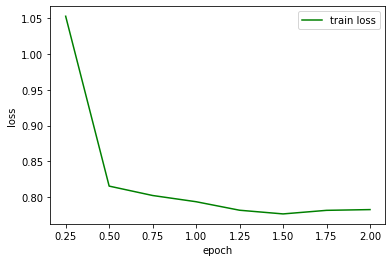

CPU times: user 41min 56s, sys: 35.3 s, total: 42min 31s
Wall time: 44min 43s


In [20]:
%%time
network = ScratchDeepNeuralNetworkClassifier()
network.fit(X_train, y_train, X_val, y_val, epochs=2)

In [21]:
%%time
pred = network.predict(X_test)

from sklearn import metrics
print(f'予測結果の正解率: {metrics.accuracy_score(y_test, pred)}')

予測結果の正解率: 0.7804
CPU times: user 1min 50s, sys: 2.1 s, total: 1min 52s
Wall time: 1min 59s


【問題7】（アドバンス課題）LeNet

【問題8】（アドバンス課題）有名な画像認識モデルの調査

・AlexNet<br>
・BN-AlexNet (batch normalized AlexNet)<br>
・BN-NIN (batch normalized Network In Network)<br>
・ENet<br>
・GoogLeNet<br>
・ResNet-18, 34, 50, 101, 152<br>
・VGG-16, 19<br>
・Inception-v3, v4<br>
・EfficientNet<br>

【問題9】出力サイズとパラメータ数の計算

1.

入力サイズ : 144×144, 3チャンネル
フィルタサイズ : 3×3, 6チャンネル
ストライド : 1
パディング : なし

2.

入力サイズ : 60×60, 24チャンネル
フィルタサイズ : 3×3, 48チャンネル
ストライド　: 1
パディング : なし

3.

入力サイズ : 20×20, 10チャンネル
フィルタサイズ: 3×3, 20チャンネル
ストライド : 2
パディング : なし

In [4]:
import numpy as np
def compute_out(N_in, padding, filter_size, stride):
    N_h_out_shape = (N_in.shape[0] + 2 * padding - filter_size.shape[0]) / stride + 1
    N_w_out_shape = (N_in.shape[1] + 2 * padding - filter_size.shape[1]) / stride + 1
    return np.zeros((int(N_h_out_shape), int(N_w_out_shape)))

In [6]:
# 1
input_size = np.zeros((144, 144))
input_channel = 3
filter_size = np.zeros((3, 3))
filter_channel = 6
bias_size = 6
stride = 1
padding = 0
out = compute_out(input_size, padding, filter_size, stride)
print(f'計算された出力サイズ：{out.shape[0]}, {out.shape[1]}')
print(f'必要なパラメータ数: {input_channel*filter_channel*filter_size.shape[0]*filter_size.shape[1] + bias_size}')

計算された出力サイズ：142, 142
必要なパラメータ数: 168


In [7]:
# 2
input_size = np.zeros((60, 60))
input_channel = 24
filter_size = np.zeros((3, 3))
filter_channel = 48
bias_size = filter_channel
stride = 1
padding = 0
out = compute_out(input_size, padding, filter_size, stride)
print(f'計算された出力サイズ：{out.shape[0]}, {out.shape[1]}')
print(f'必要なパラメータ数: {input_channel*filter_channel*filter_size.shape[0]*filter_size.shape[1] + bias_size}')

計算された出力サイズ：58, 58
必要なパラメータ数: 10416


In [8]:
# 3
input_size = np.zeros((20, 20))
input_channel = 10
filter_size = np.zeros((3, 3))
filter_channel = 20
bias_size = filter_channel
stride = 2
padding = 0
out = compute_out(input_size, padding, filter_size, stride)
print(f'計算された出力サイズ：{out.shape[0]}, {out.shape[1]}')
print(f'必要なパラメータ数: {input_channel*filter_channel*filter_size.shape[0]*filter_size.shape[1] + bias_size}')

計算された出力サイズ：9, 9
必要なパラメータ数: 1820


【問題10】（アドバンス課題）フィルタサイズに関する調査<br>
参考サイト：<br>
https://qiita.com/koshian2/items/031b6a335d0d217e4c4c<br>
https://towardsdatascience.com/deciding-optimal-filter-size-for-cnns-d6f7b56f9363<br>

・7×7などの大きめのものではなく、3×3のフィルタが一般的に使われる理由<br>
重みの共有と計算コストの削減です。画像内の異なるピクセルセットに同じカーネルを使用するので、これらのピクセルセットにコンボリューションをかける際に、同じ重みが共有されます。また、完全連結層に比べて重みの数が少ないため、逆伝播する重みも少なくて済みます。

・高さや幅方向を持たない1×1のフィルタの効果<br>
1x1畳み込みを使うと計算効率がよくなる